In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split

import tensorflow as tf

In [5]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [6]:
df = pd.read_csv('/content/drive/MyDrive/ML/dataset/age_gender.csv')
print(df.pixels.nunique())
#Finding no. of null values
print(df.pixels.isnull().sum())
#Finding repaeted rows
df_repeated = df.groupby('pixels').filter(lambda x: len(x) > 1)
print(df_repeated.head())

#FInding the no of unique rows that are repeated
print(len(df_repeated.groupby(['pixels'])))
print(len(df_repeated.groupby(['pixels', 'age', 'ethnicity', 'gender'])))

#Since there is an abnormality & confusion n the data lebels as seen by printing the values, we choose to drop the repeated rows = 765 directly. So are choosing 22940 rows for our model.
df_final = df.groupby('pixels').filter(lambda x: len(x) == 1)

#Converting pixels to array of pixels
df_final['pixels'] = df_final['pixels'].apply(lambda x: np.array(x.split(), dtype="float32"))

#printing rows and colums
print(df.shape)
print(df_final.head())
# normalizing pixels data
df_final['pixels'] = df_final['pixels'].apply(lambda x: x/255)
df_final = df_final.sample(frac=1).reset_index(drop=True)
#COnverting to list
X = np.array(df_final['pixels'].tolist())
print(X.shape)
print(X[0])
print(len(X[0]))
print(X.shape[0])
# Converting pixels from 1D to 3D
X = X.reshape(X.shape[0],48,48,1)
print(X.shape[0])
print(X[0])

23315
0
     age  ...                                             pixels
135    1  ...  43 39 31 37 33 31 39 43 70 93 118 131 153 116 ...
302    1  ...  233 214 152 91 49 33 56 94 109 104 99 92 88 94...
349    1  ...  254 238 205 193 178 195 196 196 187 183 189 17...
486    1  ...  196 196 197 197 200 201 202 202 200 201 201 20...
497    1  ...  196 196 197 197 200 201 202 202 200 201 201 20...

[5 rows x 5 columns]
375
641
(23705, 5)
   age  ...                                             pixels
0    1  ...  [129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 133...
1    1  ...  [164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175....
2    1  ...  [67.0, 70.0, 71.0, 70.0, 69.0, 67.0, 70.0, 79....
3    1  ...  [193.0, 197.0, 198.0, 200.0, 199.0, 200.0, 202...
4    1  ...  [202.0, 205.0, 209.0, 210.0, 209.0, 209.0, 210...

[5 rows x 5 columns]
(22940, 2304)
[0.5803922  0.58431375 0.4862745  ... 0.38431373 0.39215687 0.39215687]
2304
22940
22940
[[[0.5803922 ]
  [0.58431375]
  [0.4862745 ]
  ...
  [0.42

In [7]:
import seaborn as sns
sns.set()

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [8]:
y_new = np.array(df_final[['gender', 'ethnicity', 'age']])
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y_new, test_size=0.2, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train,y_train,test_size = 0.25,train_size =0.75)

y_gender_train = y_train[:,0]
y_gender_test = y_test[:,0]
y_gender_cv = y_cv[:,0]

y_age_train = y_train[:,2]
y_age_test = y_test[:,2]
y_age_cv = y_cv[:,2]

y_ethnicity_train = y_train[:,1]
y_ethnicity_test = y_test[:,1]
y_ethnicity_cv = y_cv[:,1]

#FInding the position to slice
eth_train_len = len(y_ethnicity_train)
eth_cv_len=len(y_ethnicity_cv)
#COncatenating the dataset
y_ethnicity_concat = np.concatenate((y_ethnicity_train,y_ethnicity_cv, y_ethnicity_test))

#COne hot encoding
y_ethnicity = to_categorical(y_ethnicity_concat)

y_ethnicity_train = y_ethnicity[:eth_train_len]
y_ethnicity_cv=y_ethnicity[eth_train_len:(eth_train_len+eth_cv_len)]
y_ethnicity_test = y_ethnicity[(eth_train_len+eth_cv_len):]

In [9]:
#import kerastuner as kt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import clone_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

import keras
import IPython

In [7]:
inputs = tf.keras.Input(shape=(48, 48, 1))
x = inputs

x = Conv2D(160, kernel_size=(3,3),padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(0.3)(x)

x = tf.keras.layers.MaxPool2D()(x)

x = Conv2D(192, kernel_size=(3,3),padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(0.3)(x)

x = tf.keras.layers.AvgPool2D()(x)

x = Conv2D(224, kernel_size=(3,3),padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(0.1)(x)

x = tf.keras.layers.MaxPool2D()(x)

x = Conv2D(224, kernel_size=(3,3),padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(0.1)(x)

x = tf.keras.layers.AvgPool2D()(x)

x = Conv2D(224, kernel_size=(3,3),padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(0.1)(x)

x = tf.keras.layers.MaxPool2D()(x)

x = tf.keras.layers.GlobalAvgPool2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(896,activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = layers.Dense(896,activation='relu')(x)

#bottleneck =  tf.keras.layers.GlobalMaxPool2D()(x)
out_gender = layers.Dense(1, activation='sigmoid', name='gender_out')(x) ## output binaire
out_ethnicity = layers.Dense(5, activation='softmax', name='ethnicity_out')(x) ## output catégoriel
out_age=layers.Dense(1, name='age_out')(x) ## output continue


model = tf.keras.Model(inputs=inputs, outputs=[out_gender, out_ethnicity, out_age])
model.compile(
      optimizer='rmsprop',
        loss={'gender_out':'BinaryCrossentropy',
              'ethnicity_out':'categorical_crossentropy',
              'age_out':'mse'},
        metrics={'gender_out':'accuracy',
                 'ethnicity_out':'accuracy',
                 'age_out':'mae'})
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 48, 160)  1600        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 48, 48, 160)  640         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 48, 48, 160)  0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [8]:
batch_size = 32
epochs = 40


history_list = []

In [9]:
history = model.fit(X_train, {'gender_out': y_gender_train, 'ethnicity_out': y_ethnicity_train, 'age_out': y_age_train},
                         batch_size=batch_size,
                         epochs = epochs, validation_data = (X_cv, [y_gender_cv, y_ethnicity_cv, y_age_cv]),
                         steps_per_epoch=(X_train.shape[0] // batch_size)
                         )

history_list.append(history)

Epoch 1/40
430/430 [==============================] - 582s 1s/step - loss: 255.0136 - gender_out_loss: 0.7030 - ethnicity_out_loss: 1.5435 - age_out_loss: 252.7670 - gender_out_accuracy: 0.5724 - ethnicity_out_accuracy: 0.3793 - age_out_mae: 11.7351 - val_loss: 251.4003 - val_gender_out_loss: 0.7039 - val_ethnicity_out_loss: 1.6063 - val_age_out_loss: 249.0901 - val_gender_out_accuracy: 0.5190 - val_ethnicity_out_accuracy: 0.4274 - val_age_out_mae: 12.9354
Epoch 2/40
430/430 [==============================] - 583s 1s/step - loss: 163.5423 - gender_out_loss: 0.6878 - ethnicity_out_loss: 1.4924 - age_out_loss: 161.3621 - gender_out_accuracy: 0.5922 - ethnicity_out_accuracy: 0.3963 - age_out_mae: 9.2032 - val_loss: 178.6341 - val_gender_out_loss: 0.6815 - val_ethnicity_out_loss: 1.4870 - val_age_out_loss: 176.4656 - val_gender_out_accuracy: 0.5453 - val_ethnicity_out_accuracy: 0.3819 - val_age_out_mae: 10.2306
Epoch 3/40
430/430 [==============================] - 575s 1s/step - loss: 134.

In [16]:
export_path='/content/drive/MyDrive/ML/novel_40_non_aug'
tf.saved_model.save(model, export_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/novel_40_non_aug/assets


In [11]:
export_path='/content/drive/MyDrive/ML/all_saved_models/novel_40_non_aug'
loaded_model=tf.keras.models.load_model(export_path)

In [18]:
from matplotlib import pyplot as plt

def plot_loss(his, epoch, title):
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['loss'], label='train_loss')
    plt.plot(np.arange(0, epoch), his.history['gender_out_loss'], label='train_gender_loss')
    plt.plot(np.arange(0, epoch), his.history['ethnicity_out_loss'], label='train_ethnicity_loss')
    plt.plot(np.arange(0, epoch), his.history['age_out_loss'], label='train_age_loss')
    
    plt.plot(np.arange(0, epoch), his.history['val_gender_out_loss'], label='val_train_gender_loss')
    plt.plot(np.arange(0, epoch), his.history['val_ethnicity_out_loss'], label='val_train_ethnicity_loss')
    plt.plot(np.arange(0, epoch), his.history['val_age_out_loss'], label='val_train_age_loss')
    
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()
def plot_acc(his, epoch, title):
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['gender_out_accuracy'], label='train_gender_acc')
    plt.plot(np.arange(0, epoch), his.history['ethnicity_out_accuracy'], label='train_ethnicity_accuracy')
        
    plt.plot(np.arange(0, epoch), his.history['val_gender_out_accuracy'], label='val_gender_acc')
    plt.plot(np.arange(0, epoch), his.history['val_ethnicity_out_accuracy'], label='val_ethnicity_accuracy')


    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()
def plot_MSE(his, epoch, title):
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['age_out_mae'], label='train_age_mae')
    plt.plot(np.arange(0, epoch), his.history['val_age_out_mae'], label='val_age_mae')

    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Mean Absolute Error')
    plt.legend(loc='upper right')
    plt.show()

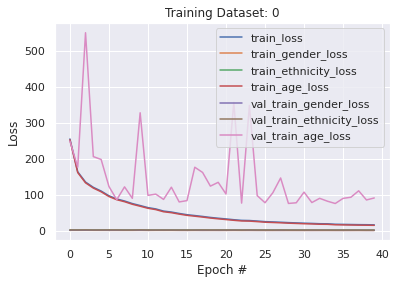

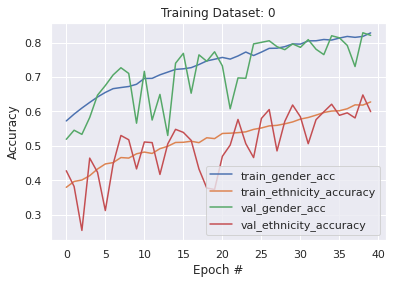

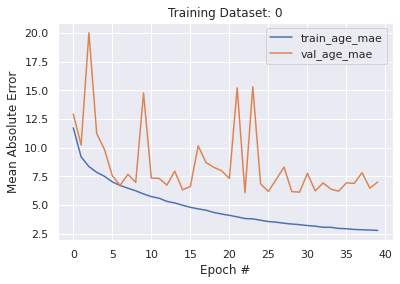

In [13]:
plot_loss(history_list[0], epochs, f'Training Dataset: {0}')
plot_acc(history_list[0], epochs, f'Training Dataset: {0}')
plot_MSE(history_list[0], epochs, f'Training Dataset: {0}')

In [12]:
pred = loaded_model.predict(X_test)

test_loss,test_gender_loss, test_ethnicity_loss, test_age_loss, test_gender_acc,test_ethnicity_acc,test_age_mae = loaded_model.evaluate(X_test, [y_gender_test, y_ethnicity_test, y_age_test], verbose=0)
print(f'\nTest gender accuracy: {test_gender_acc}')
print(f'\nTest ethnicity accuracy: {test_ethnicity_acc}')
print(f'\nTest age MAE: {test_age_mae}')


Test gender accuracy: 0.8247602581977844

Test ethnicity accuracy: 0.5978639721870422

Test age MAE: 5.013856410980225


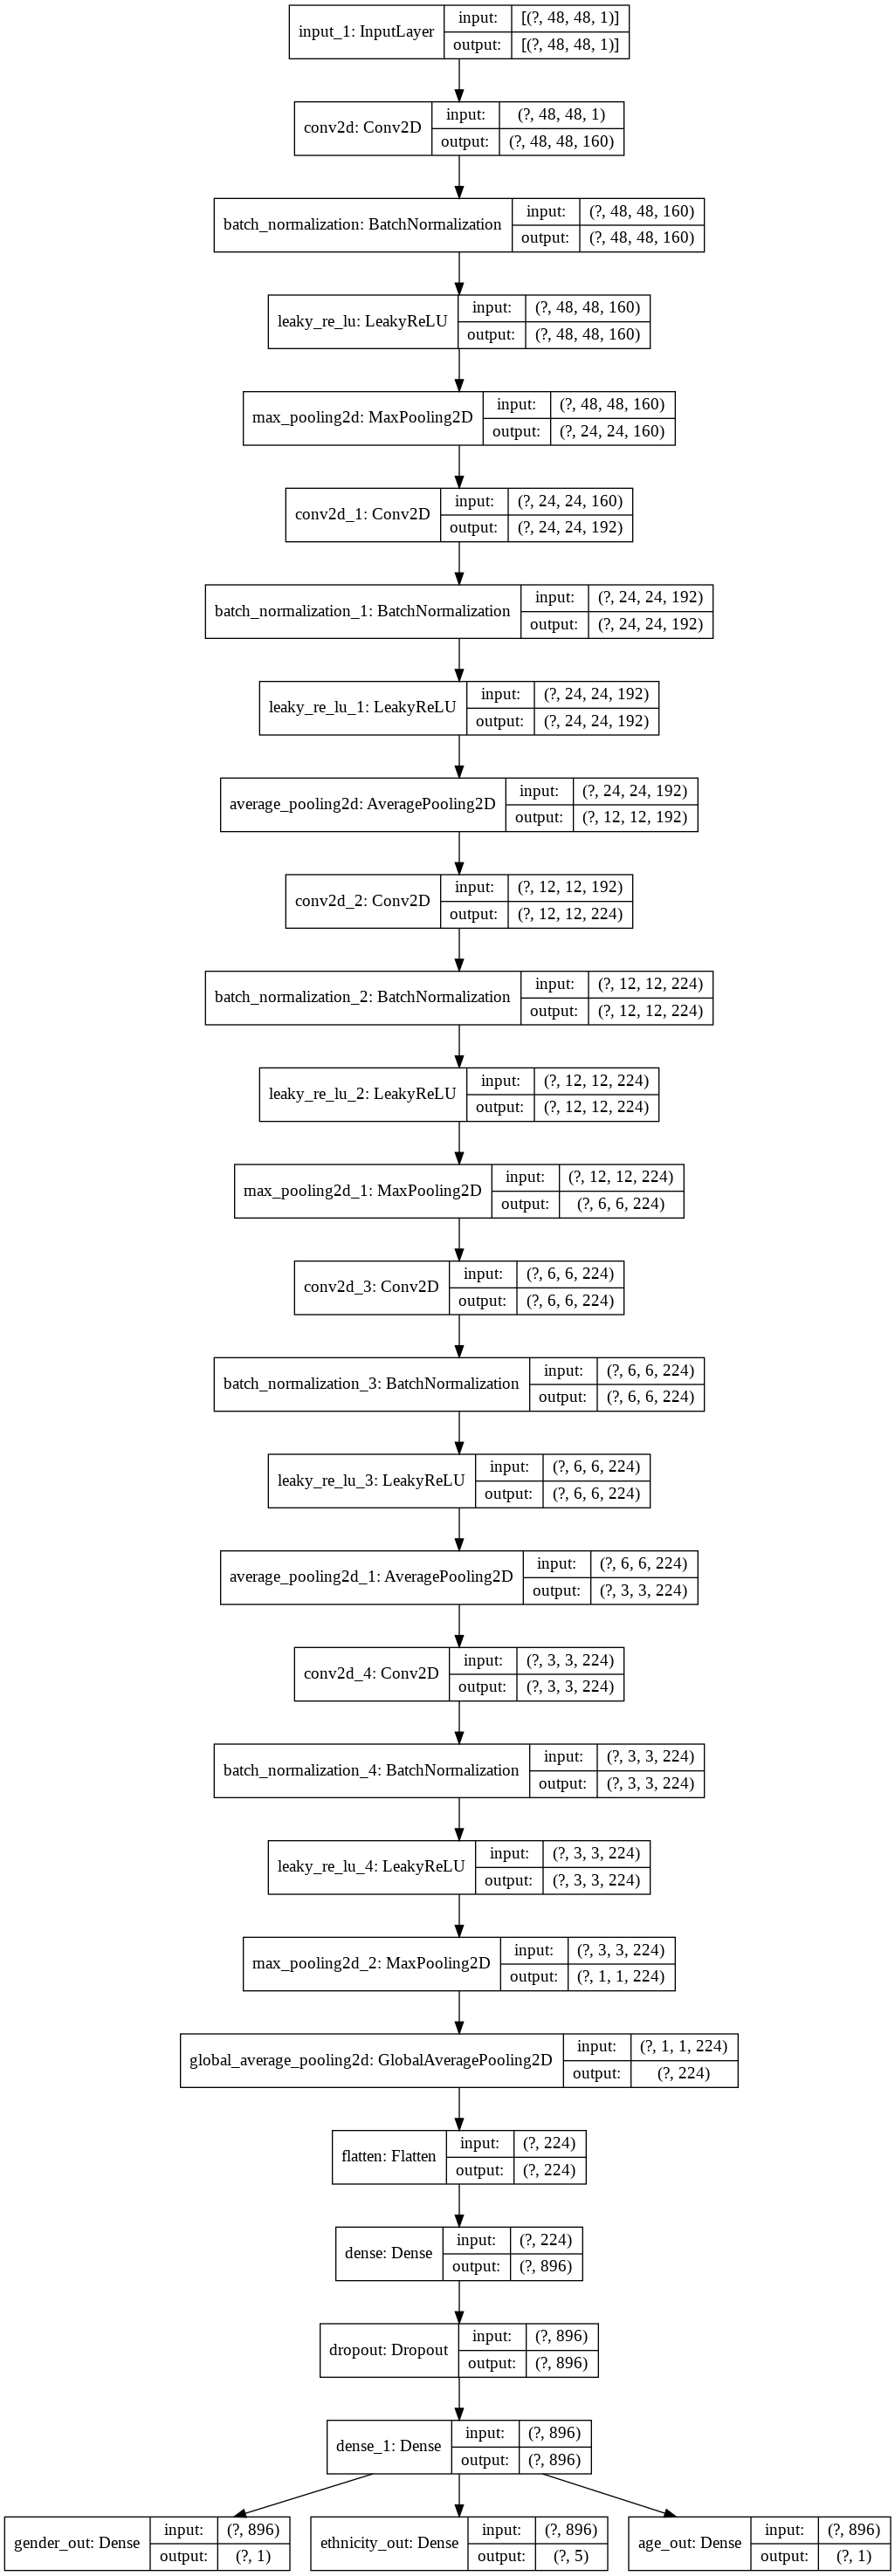

In [25]:
# tf.keras.utils.plot_model(
#     model, to_file='model.png', show_shapes=True, show_layer_names=True,
#     rankdir='TB', expand_nested=True, dpi=96
# )

In [14]:
#Confution Matrix and Classification Report Gender

from sklearn.metrics import classification_report, confusion_matrix
Y_pred_gender = np.argmax(pred[0])
Y_true_gender = np.argmax(y_gender_test)
print('Confusion Matrix')
print(confusion_matrix(Y_true_gender, Y_pred_gender))
print('Classification Report')
target_names = ['Woman', 'Man']
print(classification_report(Y_true_gender, Y_pred_gender, target_names=target_names))

Confusion Matrix


TypeError: ignored

In [22]:
pr=np.round(pred[0])
print(pr)
print(y_gender_test)

[[0.]
 [0.]
 [1.]
 ...
 [0.]
 [1.]
 [0.]]
[0 0 1 ... 0 1 0]


Confusion Matrix
Classification Report
              precision    recall  f1-score   support

        Male       0.81      0.87      0.84      2384
      Female       0.85      0.77      0.81      2204

    accuracy                           0.82      4588
   macro avg       0.83      0.82      0.82      4588
weighted avg       0.83      0.82      0.82      4588



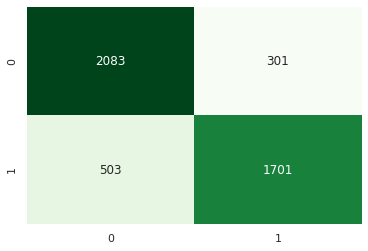

In [25]:
# Confusion matrix
np.round(pred[0], 2)
Y_pred_gender = pred[0]
Y_true_gender = y_gender_test
cm = confusion_matrix(Y_true_gender,pr)
print("Confusion Matrix")
#np.fill_diagonal(cm, 0) #Fill diagonal with 0 for better visualisation
sns.heatmap(cm, annot=True, fmt='d', cbar=False, cmap='Greens');
print('Classification Report')
target_names = ['Male', 'Female']
print(classification_report(Y_true_gender, pr, target_names=target_names))

In [2]:
print('Classification Report')
from sklearn.metrics import classification_report, confusion_matrix
target_names = ['male', 'female']
print(classification_report(Y_true_gender, pr, target_names=target_names))

Classification Report


NameError: ignored

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred_Ethn = np.argmax(pred[1],axis=1)
Y_true_ethnicity = np.argmax(y_ethnicity_test,axis = 1)
print('Confusion Matrix')
print(confusion_matrix(Y_true_ethnicity, Y_pred_Ethn))
print('Classification Report')
target_names = ['0', '1','2','3','4']
print(classification_report(Y_true_ethnicity, Y_pred_Ethn, target_names=target_names))

Confusion Matrix
[[1540   25   20  344    0]
 [ 223  481    3  155    1]
 [ 345   13  197  115    6]
 [ 230   18    6  537    2]
 [ 175   10    4  133    5]]
Classification Report
              precision    recall  f1-score   support

           0       0.61      0.80      0.69      1929
           1       0.88      0.56      0.68       863
           2       0.86      0.29      0.43       676
           3       0.42      0.68      0.52       793
           4       0.36      0.02      0.03       327

    accuracy                           0.60      4588
   macro avg       0.62      0.47      0.47      4588
weighted avg       0.65      0.60      0.58      4588



Confusion Matrix


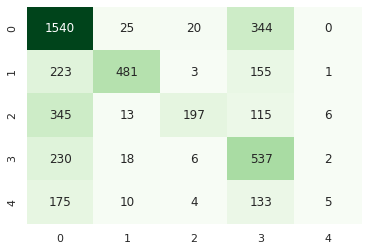

In [29]:
cm = confusion_matrix(Y_true_ethnicity,Y_pred_Ethn)
print("Confusion Matrix")
#np.fill_diagonal(cm, 0) #Fill diagonal with 0 for better visualisation
sns.heatmap(cm, annot=True, fmt='d', cbar=False, cmap='Greens');

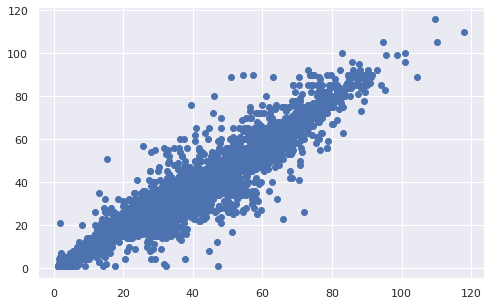

In [42]:
plt.figure(figsize=(8, 5))
plt.scatter(pred[2], y_age_test);

In [41]:
print(pred[2])

[[ 3.3835535]
 [28.200047 ]
 [26.490473 ]
 ...
 [64.48778  ]
 [29.840824 ]
 [30.025623 ]]
